# RadioML dataset - 2016.10A
----

- It is a synthetic dataset generated with GNU Radio.
- Consists of 11 modulations (8 digital and 3 analog) - E.g. - `8PSK`, `QPSK`, etc. Along with varying SNR ratios.
- [Source](https://www.deepsig.ai/datasets).

In [21]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score
plt.rcParams["figure.figsize"] = (18,7)
plt.rcParams.update({'font.size': 15})
plt.style.use('fivethirtyeight')

In [22]:
# Import the pickled raw file
path = "/Volumes/DHIRAJ/B.Tech/Project-1/RML2016.10a_dict.pkl"
with open(path, 'rb') as pic_file:
    data = pickle.load(pic_file, encoding='latin1')

## About the dataset -
---

In [3]:
snr_vals, mod_classes = map(lambda j: sorted(list(set(map(lambda x: x[j], data.keys())))), [1,0])
print("Data is originally stored in a dictionary format with keys as (modulation, SNR value).")
print(f"Input Data shape: {data[('QAM16', 18)].shape}")
print(f"Total labels: {len(data.keys())}")
print(f"Modulation Techniques: {mod_classes}")
print(f"SNR values: {snr_vals}")

Data is originally stored in a dictionary format with keys as (modulation, SNR value).
Input Data shape: (1000, 2, 128)
Total labels: 220
Modulation Techniques: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
SNR values: [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


## Exploratory Data analysis
---

### Different signal representations
---

Various signal representations used are
- 

In [4]:
def plot_data(samples, mod_name, SNR, plot_type="iq"):
    I_values = samples[0]
    Q_values = samples[1]
    signal = I_values + 1j * Q_values
    if plot_type == "iq":
        plt.plot(I_values, label="I values", c='r', linewidth=3, alpha=0.75)
        plt.plot(Q_values, label="Q values", linewidth=3, alpha=0.75)
        plt.plot(np.abs(signal), label="Amplitude", c='b', linewidth=4, alpha=0.85)
        plt.title(f"IQ/Amplitude Vs Time{mod_name}-{str(SNR)}")
        plt.xlabel("Time in $\mu s$")
        plt.legend()
        plt.savefig(f"{mod_name}-{SNR}-IQ-plot.png")
        plt.show()
    if plot_type == "ph_amp":
        plt.subplot(1,2,1)
        plt.suptitle(f"Amplitude and Phase Vs Time ({mod_name}-{str(SNR)})")
        plt.plot(np.abs(signal), label="Amplitude", c='b', linewidth=3, alpha=0.75)
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(np.angle(signal), label="Phase", c='g', linewidth=3, alpha=0.75)
        plt.legend()
        plt.savefig(f"{mod_name}-{SNR}-AP-plot.png")
        plt.show()
    if plot_type == "spec":
        spec = plt.specgram(signal, Fs=1000, mode='magnitude')
        plt.colorbar()
        plt.title(f"{mod_name}-{str(SNR)}")
        plt.show()

In [20]:
plot_data(data[("QPSK", 10)][0], "QPSK", 10, "iq")
plot_data(data[("QPSK", 10)][0], "QPSK", 10, "ph_amp")
# plot_data(data[("QPSK", 10)][0], "QPSK", 10, "spec")
# plot_data(data[("AM-SSB", 10)][0], "AM-SSB", 10, "iq")
# plot_data(data[("AM-SSB", 10)][0], "AM-SSB", 10, "ph_amp")

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [6]:
# ex = data[("QAM16", 18)][0]
# i = ex[0]
# q = ex[1]
# c = i + 1j * q
# s = plt.specgram(c,  Fs=1000000, mode='psd')
# plt.colorbar()
# plt.show()
# plt.plot(s[1], s[0])
# plt.show()

# Data Preprocessing
---
Steps -

1. Remove the analog modulation techniques.
2. Separate the training and testing data - Using `60%` (600/1000) for training and `40%` for testing.
3. Create appropriate labels for the training step

In [8]:
analog_mods = ['WBFM', 'CPFSK','PAM4', 'QAM64']
removed_keys = [key for key in data if key[0] in analog_mods]
digital_data = {key: data[key] for key in data if key not in removed_keys}
digital_snrs, digital_mods = map(lambda j: sorted(list(set(map(lambda x: x[j], digital_data.keys())))), [1,0])
print(f"Total digital (mods, SNR) pairs (labels): {len(digital_data.keys())}")
print(f"Digital Mods: {digital_mods}")

Total digital (mods, SNR) pairs (labels): 140
Digital Mods: ['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'GFSK', 'QAM16', 'QPSK']


In [9]:
train_test_ratio = 0.6
train_dict = {}
test_dict = {}
for key, value in digital_data.items():
    train_dict.update({key: value[:int(value.shape[0] * train_test_ratio), :]})
    test_dict.update({key: value[int(value.shape[0] * train_test_ratio):, :]})
print(f"Original Training set dimensions: {train_dict[('8PSK',2)].shape}")
print(f"Original Testing set dimensions: {test_dict[('8PSK',2)].shape}")

Original Training set dimensions: (600, 2, 128)
Original Testing set dimensions: (400, 2, 128)


In [10]:
train_snrs, train_mods = map(lambda j: sorted(list(set(map(lambda x: x[j], train_dict.keys())))), [1,0])
X_train = []  
train_labels = []
for mod in train_mods:
    for snr in train_snrs:
        X_train.append(train_dict[(mod, snr)])
        for sample_number in range(train_dict[(mod,snr)].shape[0]):
            train_labels.append((mod,snr))
X_train = np.vstack(X_train)
n_samples_train, dim1, dim2 = X_train.shape 
y_train = np.array(list(map(lambda x: train_mods.index(train_labels[x][0]), range(n_samples_train))))
print(f"Training dimensions (all features): ", X_train.shape)

Training dimensions (all features):  (84000, 2, 128)


In [11]:
test_data = defaultdict(list)
test_labels = defaultdict(list)
def get_test_data_snr(snr):
    for key, val in test_dict.items():
        if key[1] == snr:
            test_data[snr].append(val)
            for x in range(val.shape[0]):
                # For every sample with that SNR value
                test_labels[snr].append(key[0]) # Save the mod name
    test_data[snr] = np.vstack(test_data[snr])
    n_samples_test = test_data[snr].shape[0]
    test_labels[snr] = np.array(list(map(lambda x: train_mods.index(test_labels[snr][x]), range(n_samples_test))))
    return test_data[snr], test_labels[snr]

X_test = defaultdict(list)
y_test = defaultdict(list)
for snr in train_snrs:
    data, labels = get_test_data_snr(snr)
    X_test[snr].append(data)
    X_test[snr] = np.vstack(X_test[snr])
    y_test[snr].append(labels)
    y_test[snr] = np.hstack(y_test[snr])

## Feature Extraction
----


In [12]:
def compute_standard_deviation(A, B, count):
    sigma = np.power(A/count - np.power(B/count, 2), 0.5)
    return sigma

In [13]:
def extract_features(X):
    FS = 1000 # 1000kHz
    FC = 45 # 45kHz
    features = np.zeros([len(X), 8]) # Start with 8 features
    for ex_no in range(X.shape[0]):
        real_I = X[ex_no][0]
        imag_Q = X[ex_no][1]
        index_record = np.array([], dtype=int) # To hold the index for > threshold
        signal = real_I + imag_Q * 1j # Construct the signal
        total_frames = len(signal)
        # Amplitude computations
        A_i = np.power(np.power(real_I, 2) + np.power(imag_Q, 2), 0.5)
        A_n = A_i / np.mean(A_i)
        A_cn = A_n - 1
        # Phase computations
        threshold_a_cn = np.zeros(total_frames)
        phase = np.angle(signal)
        phi_unwrap = np.unwrap(phase)
        phi_NL = np.zeros(total_frames)
        # Unwrap the phase then,
        # Subtract the linear part of the phase.
        for i in range(total_frames):
            if A_n[i] > 1:
                phi_NL[i] = phi_unwrap[i] - (2 * np.pi * FC * i / FS)
                index_record = np.append(index_record, i)
                threshold_a_cn[i] = A_cn[i]
            
        phase_squared = np.sum(np.power(phi_NL, 2))
        phase_abs = np.sum(np.abs(phi_NL))
        phase_sum = np.sum(phi_NL)
        thresh_acn_squared = np.sum(np.power(threshold_a_cn, 2))
        thresh_acn_sum = np.sum(threshold_a_cn)
        FN = np.zeros(len(index_record)-1)

        # Frequency computations
        for index, thresh_index in enumerate(index_record):
            if index < len(index_record)-1:
                FN[index] = (phi_NL[index_record[index+1]] - phi_NL[thresh_index]) / (2*np.pi)
        Fn_squared = np.sum(np.power(FN, 2))
        Fn_abs = np.sum(np.abs(FN))
        
        # Statistical features
        deviations = signal - np.mean(signal)

        #### Compute the features one by one

        gamma_max = np.max(np.power(np.abs(np.fft.fft(A_cn)), 2)) / total_frames
        sigma_aa = np.power(np.mean(np.power(A_cn, 2)) - np.power(np.mean(np.abs(A_cn)),2), 0.5)
        sigma_ap = compute_standard_deviation(phase_squared, phase_abs, len(index_record))
        sigma_dp = compute_standard_deviation(phase_squared, phase_sum, len(index_record))
        sigma_a = compute_standard_deviation(thresh_acn_squared, thresh_acn_sum, len(index_record))
        sigma_nf = compute_standard_deviation(Fn_squared, Fn_abs, len(index_record))
        Kurtosis = np.abs(np.mean(np.power(deviations, 4)) / np.power(np.mean(np.power(deviations, 2)), 2))
        Skewness = np.abs(np.mean(np.power(deviations, 3)) / np.power(np.mean(np.power(deviations, 2)), 1.5))
        
        #### Store the features
        features[ex_no][0] = gamma_max
        features[ex_no][1] = sigma_ap
        features[ex_no][2] = sigma_dp
        features[ex_no][3] = sigma_aa
        features[ex_no][4] = sigma_a
        features[ex_no][5] = sigma_nf
        features[ex_no][6] = Kurtosis
        features[ex_no][7] = Skewness
    return features

In [14]:
print("=== Computing features ===")
X_train_features = extract_features(X_train)
print(f"Train features dimension: {X_train_features.shape}")

=== Computing features ===
Train features dimension: (84000, 8)


# Model Building
---

## Decision Tree based learning

In [15]:
decision_classifier = DecisionTreeClassifier()
decision_classifier.fit(X_train_features, y_train)
decision_classifier

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [16]:
# svm = SVC(kernel='linear')
# svm.fit(X_train_features, y_train)

# Model Evaluation
----


In [16]:
def calculate_accuracy(model, snrs):
    """This function takes a classifier and range of SNR values,
    and returns the accuracy at different SNRs"""
    accuracy = []
    for snr in snrs:
        X_test_features = extract_features(X_test[snr])
        pred = model.predict(X_test_features)
        accuracy.append(accuracy_score(y_test[snr], pred))
    return accuracy

In [17]:
print("Feature importance: ")
decision_classifier.feature_importances_

Feature importance: 


array([0.18423906, 0.08141207, 0.07717622, 0.09312083, 0.15237603,
       0.11423222, 0.18068789, 0.11675568])

In [18]:
accuracy = calculate_accuracy(decision_classifier, train_snrs)

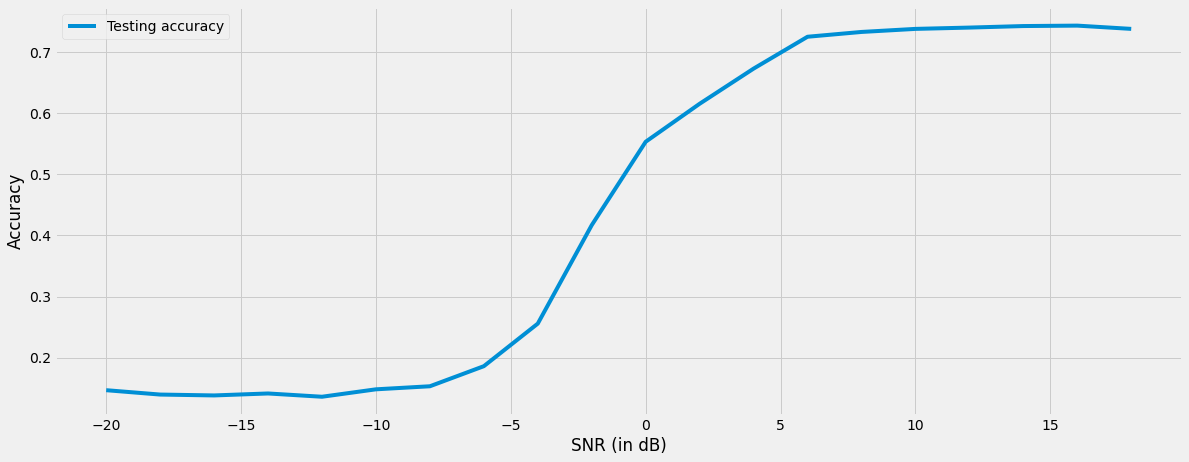

In [19]:
plt.plot(train_snrs, accuracy, label="Testing accuracy")
plt.xlabel("SNR (in dB)")
plt.ylabel("Accuracy")
plt.legend()